In [1]:
import os
from tqdm import tqdm
from io import BytesIO
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.utils.tensorboard.writer import SummaryWriter
from torch.profiler import profile, record_function, ProfilerActivity
import torch
from model import GVAE
from loss import reconstruction_loss, kl_loss
from dataset import SketchDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data._utils.collate import default_collate
os.chdir('SketchGraphs/')
import sketchgraphs.data as datalib
os.chdir('../')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
dataset = SketchDataset(root="data/")

generator = torch.Generator().manual_seed(4)
train_set, validate_set, test_set = random_split(dataset = dataset, lengths = [0.9, 0.033, 0.067], generator = generator)

print("Number of Graphs in total: ", dataset.len())
print("Number of Graphs for training: ", len(train_set))
print("Number of Graphs for validation: ", len(validate_set))
print("Number of Graphs for testing: ", len(test_set))

Number of Graphs in total:  4461655
Number of Graphs for training:  4015490
Number of Graphs for validation:  147235
Number of Graphs for testing:  298930


In [3]:
batch_size = 128
learning_rate = 1e-3
num_epochs = 10

In [4]:
# train_loader = DataLoader(dataset = train_set, batch_size = batch_size, persistent_workers = True, num_workers = 8, pin_memory = True)

In [ ]:
# for batch_index, (nodes, edges, node_params_mask) in enumerate(train_loader):
#     nodes = nodes.to(device)
#     edges = edges.to(device)
#     node_params_mask = node_params_mask.to(device)
#     print(batch_index)

In [12]:
train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
validate_loader = DataLoader(dataset = validate_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)

model = GVAE(device)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

writer = SummaryWriter('runs/gvae_experiment_2')

In [ ]:
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#     with record_function("data_loading"):
#         for i in range(10):
#             nodes, edges, params_mask = default_collate(train_set[i*batch_size:(1+i)*batch_size])
#             optimizer.zero_grad()

#             target_nodes = nodes.to(device)
#             target_edges = edges.to(device)
#             node_params_mask = node_params_mask.to(device)
    
#             pred_nodes, pred_edges, means, logvars = model(target_nodes, target_edges)
    
#             loss = reconstruction_loss(pred_nodes, pred_edges, target_nodes, target_edges, node_params_mask) + kl_loss(means, logvars)
#             loss.backward()
#             optimizer.step()

#         print("done")


In [ ]:

# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

In [5]:
def figure_to_tensor(figure):
    """
    Convert a Matplotlib figure to a PyTorch tensor.

    :param figure: Matplotlib figure to convert.
    :return: PyTorch tensor.
    """
    # Convert the Matplotlib figure to a NumPy array
    buf = BytesIO()
    figure.savefig(buf, format='png')
    buf.seek(0)
    image = plt.imread(buf)

    # Convert the NumPy array to a PyTorch tensor
    transform = transforms.ToTensor()
    tensor = transform(image)

    return tensor

In [ ]:
best_validation_loss = float('inf')

for epoch in range(num_epochs):
    # Train Model for one epoch
    print(f"Epoch {epoch} Training model ---")
    model.train()
    total_train_loss = 0.0
    num_train_batches = 0
    for batch_idx, (nodes, edges, node_params_mask) in enumerate(train_loader):
        optimizer.zero_grad()

        target_nodes = nodes.to(device)
        target_edges = edges.to(device)
        node_params_mask = node_params_mask.to(device)

        pred_nodes, pred_edges, means, logvars = model(target_nodes, target_edges)

        loss = reconstruction_loss(pred_nodes, pred_edges, target_nodes, target_edges, node_params_mask) + kl_loss(means, logvars)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        num_train_batches += 1
        # Log training loss every 100 mini-batches
        if batch_idx % 100 == 0 and batch_idx > 0:
            avg_train_loss = total_train_loss / num_train_batches  # Calculate average up to the current batch
            writer.add_scalar("Training Loss", avg_train_loss, epoch * len(train_loader) + batch_idx)
    
    # Validate Model at end of epoch
    print(f"Epoch {epoch} Validating model ---")
    model.eval()
    total_validate_loss = 0.0
    num_validate_batches = 0
    for batch_idx, (nodes, edges, node_params_mask) in enumerate(validate_loader):
        target_nodes = nodes.to(device)
        target_edges = edges.to(device)
        node_params_mask = node_params_mask.to(device)

        pred_nodes, pred_edges, means, logvars = model(target_nodes, target_edges)

        loss = reconstruction_loss(pred_nodes, pred_edges, target_nodes, target_edges, node_params_mask) + kl_loss(means, logvars)

        total_validate_loss += loss.item()
        num_validate_batches += 1
    
    # Calculate and log the average validation loss for this epoch
    avg_validate_loss = total_validate_loss / num_validate_batches  # Calculate average up to the last batch
    writer.add_scalar("Validation Loss", avg_validate_loss, epoch)

    # Save the model checkpoint if the validation loss improves
    if avg_validate_loss < best_validation_loss:
        best_validation_loss = avg_validate_loss
        checkpoint_path = f"best_model_checkpoint.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved model checkpoint with validation loss: {best_validation_loss:.4f} to {checkpoint_path}")


In [ ]:

# Test Model
print(f"Testing model ---")
model.eval()
total_test_loss = 0.0
num_test_batches = 0
for batch_idx, (nodes, edges, node_params_mask) in enumerate(test_loader):
    target_nodes = nodes.to(device)
    target_edges = edges.to(device)
    node_params_mask = node_params_mask.to(device)

    pred_nodes, pred_edges, means, logvars = model(target_nodes, target_edges)
    
    loss = reconstruction_loss(pred_nodes, pred_edges, target_nodes, target_edges, node_params_mask) + kl_loss(means, logvars)

    total_test_loss += loss.item()
    num_test_batches += 1

writer.add_scalar("Test Loss", total_test_loss / num_test_batches)


torch.Size([24, 20])
torch.Size([24, 24, 17])
Sketch(n_entities=24, n_constraints=571)


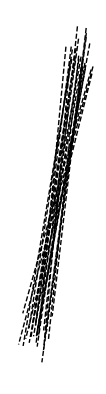

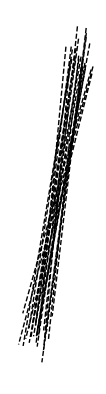

In [11]:
model.eval()
nodes, edges = model.sample_graph()
print(nodes.shape)
print(edges.shape)
sketch = SketchDataset.preds_to_sketch(nodes.cpu(), edges.cpu())
print(sketch)
datalib.render_sketch(sketch)